# Activation function plotter 
Takes the csv file with the LUT inputs and LUT outputs and converts the binary fixed point to decimal. \
Plotting the input against the output compared with the real scaled tanh function. 

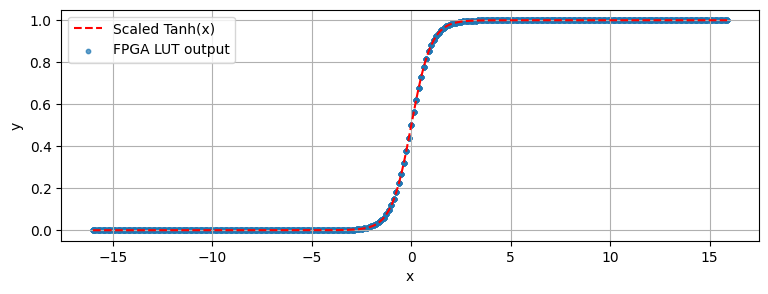

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

def fixed_point_signed_str_to_float(bit_str, fractional_bits):
    """
    Two's complement interpretation for bit_str, then scale by 2^-fractional_bits.
    """
    total_bits = len(bit_str)
    raw_value = int(bit_str, 2)
    sign_bit = 1 << (total_bits - 1)
    wrap_val = 1 << total_bits
    
    if raw_value & sign_bit:
        signed_val = raw_value - wrap_val
    else:
        signed_val = raw_value
    
    return signed_val / float(1 << fractional_bits)


def fixed_point_unsigned_str_to_float(bit_str, fractional_bits):
    """
    Unsigned interpretation in [0..2^N - 1], then scale by 2^-fractional_bits.
    """
    raw_value = int(bit_str, 2)
    return raw_value / float(1 << fractional_bits)


FRACTIONAL_BITS_IN = 3    # For an 8-bit signed Q4.3
FRACTIONAL_BITS_OUT = 32  # For a 32-bit unsigned [0..1) with 32 fractional bits

# 1) Read CSV
df = pd.read_csv("Tanh_output.csv", dtype=str)

# 2) Clean up column names
df.rename(columns=lambda x: x.strip(), inplace=True)

# # 3) Zero-fill Tanh_LUT_in to 8 bits
df["Tanh_LUT_in"] = df["Tanh_LUT_in"].apply(lambda s: s.zfill(8))

# # 4) Zero-fill Tanh_LUT_out to 32 bits (if needed)
df["Tanh_LUT_out"] = df["Tanh_LUT_out"].apply(lambda s: s.zfill(32))

# 5) Convert columns
df["Tanh_LUT_in_float"] = df["Tanh_LUT_in"].apply(
    lambda bstr: fixed_point_signed_str_to_float(bstr, FRACTIONAL_BITS_IN)
)
df["Tanh_LUT_out_float"] = df["Tanh_LUT_out"].apply(
    lambda bstr: fixed_point_unsigned_str_to_float(bstr, FRACTIONAL_BITS_OUT)
)

# print(df)

def tanh_scaled(x):
    return (np.tanh(x)+1)/2

plt.figure(figsize=(9, 3))
plt.plot(df["Tanh_LUT_in_float"], tanh_scaled(df["Tanh_LUT_in_float"]), color='r', linestyle='dashed',label='Scaled Tanh(x)')
plt.scatter(df["Tanh_LUT_in_float"], df["Tanh_LUT_out_float"], s=10, alpha=0.7, label='FPGA LUT output')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
# plt.title("Tanh LUT - Input vs Output")
plt.grid(True)
file_name = f"Tanh_LUT_FPGAsim.png"
plt.savefig(os.path.join("Plots", file_name), dpi=300)
plt.show()
